#### Risk analysis for Stock Market

Enter List of the stocks in your portfolio:

In [108]:
stock_list = ['AMZN','AAPL','AGN','HD','NPTN','SILC','MA','FB','BNFT','NXPI']

Enter Name of the individual stock for Monte Carlo analysis:

In [109]:
stock_name = 'NPTN'

In [110]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
import pandas_datareader.data as web

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [111]:
# Set up End and Start times for data grab
end = datetime.now()

start = datetime(end.year-2,end.month,end.day)

closing_df = web.DataReader(stock_list,'yahoo',start,end)['Adj Close']

In [112]:
closing_df.head()

,AAPL,AGN,AMZN,BNFT,FB,HD,MA,NPTN,NXPI,SILC
Date,,,,,,,,,,
2014-09-11,97.637642,232.740005,330.519989,33.470001,77.919998,85.682735,74.508227,3.00,71.339996,27.466734
2014-09-12,97.859046,234.380005,331.190002,33.049999,77.480003,85.317796,74.360431,3.38,69.980003,26.875257
2014-09-15,97.830161,234.839996,323.890015,31.990000,74.580002,85.836387,74.133809,3.27,68.559998,26.847531
2014-09-16,97.088954,238.759995,327.760010,31.670000,76.080002,86.691101,75.463959,3.24,70.260002,26.801323
2014-09-17,97.782035,237.089996,324.000000,31.590000,76.430000,87.603441,75.099404,3.23,70.730003,27.503703


In [113]:
tech_rets = closing_df.pct_change()
tech_rets.head()

,AAPL,AGN,AMZN,BNFT,FB,HD,MA,NPTN,NXPI,SILC
Date,,,,,,,,,,
2014-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-12,0.002268,0.007046,0.002027,-0.012549,-0.005647,-0.004259,-0.001984,0.126667,-0.019064,-0.021534
2014-09-15,-0.000295,0.001963,-0.022042,-0.032073,-0.037429,0.006078,-0.003048,-0.032544,-0.020292,-0.001032
2014-09-16,-0.007576,0.016692,0.011948,-0.010003,0.020113,0.009957,0.017943,-0.009174,0.024796,-0.001721
2014-09-17,0.007139,-0.006994,-0.011472,-0.002526,0.004600,0.010524,-0.004831,-0.003086,0.006689,0.026207


#### Risk Analysis

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

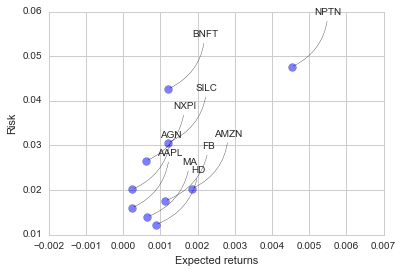

In [114]:
# Let's start by defining a new DataFrame as a clenaed version of the oriignal tech_rets DataFrame
rets = tech_rets.dropna()

area = np.pi*20

plt.scatter(rets.mean(), rets.std(),alpha = 0.5,s =area)

# Set the x and y limits of the plot (optional, remove this if you don't see anything in your plot)
plt.ylim([0.01,0.06])
plt.xlim([-0.002,0.007])

#Set the plot axis titles
plt.xlabel('Expected returns')
plt.ylabel('Risk')

# Label the scatter plots, for more info on how this is done, chekc out the link below
# http://matplotlib.org/users/annotations_guide.html
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

In [115]:
days = 2*365

dt = 1/days

mu = rets.mean()[stock_name]

sigma = rets.std()[stock_name]

In [116]:
def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    drift = np.zeros(days)
    shock = np.zeros(days)
    
    for x in xrange(1,days):
        drift[x] = mu * dt
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        price[x] = price[x-1] + price[x-1] * (drift[x]+shock[x])
        
    return price
    

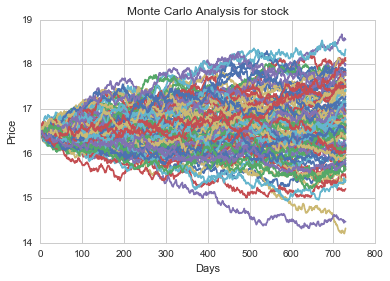

In [117]:
start_price = closing_df[stock_name][-1:]
for run in xrange(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")
plt.title('Monte Carlo Analysis for stock')

In [118]:
# Set a large numebr of runs
runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in xrange(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];

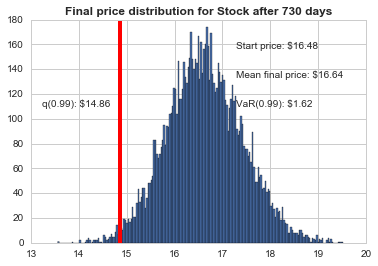

In [119]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for Stock after %s days" % days, weight='bold');